In [24]:
# ----------------------------
# Andres Graterol 
# EEL 5678 
# 4031393
# ---------------------------
# NN solution for the Concrete Cracks classification 
# ---------------------------
import os
import warnings
import cv2
import numpy as np
import random 
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision.transforms.functional as T
from tensorflow import keras
from sklearn.model_selection import train_test_split

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found. Please check tensorflow setup")
else:
    print(tf.test.gpu_device_name())
print(tf.test.is_built_with_cuda())

True


C:\Users\angel\AppData\Local\Temp\ipykernel_13892\2261384788.py:21: UserWarning: No GPU found. Please check tensorflow setup
  warnings.warn("No GPU found. Please check tensorflow setup")


In [27]:
def BasicTransforms(image):
    image = Image.fromarray(image)

    rotation_choice = random.randint(0, 1)

    if (rotation_choice == 1):
        #print("we rotated an image")
        rotation_angle = random.randint(0, 360)
        image = T.rotate(image, rotation_angle)

    flip_choice = random.randint(0, 1)

    if (flip_choice == 1):
        #print("we flipped an image")
        image = T.hflip(image)

    image = np.array(image)

    return image

def data_preprocessing(negative_pics, positive_pics, is_noisy, transform_style=None):
    # Class 0 => No cracks 
    # Class 1 => Cracks 

    # Before reshape => (20000, 227, 227)
    # Want => (20000, 51529, 1)
    negative_images = []

    # Iterate over the folder with no cracks  
    for picture in os.scandir(negative_pics):
        if picture.is_file():
            pic_path = negative_pics + '/' + picture.name
            image = cv2.imread(pic_path)

            if (transform_style == 'Basic'):
                image = BasicTransforms(image)

            # Remove 3 channels 
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Resize the image if it is part of the independent dataset 
            if (is_noisy):
                gray_image = cv2.resize(gray_image, (227, 227), interpolation=cv2.INTER_AREA)

            # Each image is (227, 227, 3)
            # Grayscale => (227, 227, 1)
            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            # Add extra last column to help with labeling
            data = np.append(data, 0)
            negative_images.append(data)

    print("Shape of negative images", np.array(negative_images).shape)
    positive_images = []

    # Iterative over the folder with cracks
    for picture in os.scandir(positive_pics):
        if picture.is_file():
            pic_path = positive_pics + '/' + picture.name
            image = cv2.imread(pic_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            if (is_noisy):
                gray_image = cv2.resize(gray_image, (227, 227), interpolation=cv2.INTER_AREA)

            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            data = np.append(data, 1)
            positive_images.append(data)
        
    print("Shape of positive images", np.array(positive_images).shape)
    #print(positive_images)

    all_images = np.concatenate((negative_images, positive_images))

    np.random.shuffle(all_images)

    # Do not split the data if we have a noisy dataset 
    if (is_noisy):
        x_noisy = all_images
        y_noisy = []

        for point in x_noisy:
            if (point[-1] == 0):
                y_noisy.append([1, 0])
            if (point[-1] == 1):
                y_noisy.append([0, 1])
        
        # drop the label point 
        x_noisy = np.delete(x_noisy, obj=-1, axis=1)
        x_noisy = x_noisy.astype('float32')
        # Normalize the data
        x_noisy /= 255
        #x_train = x_train[:, :, np.newaxis]

        x_noisy = np.asarray(x_noisy)
        y_noisy = np.asarray(y_noisy)

        return (x_noisy, y_noisy)

    # 75 and 25 split (30000) and (10000)
    x_train, x_test = all_images[:30000], all_images[30000:]

    y_train = []
    y_test = []

    for point in x_train:
        if (point[-1] == 0):
            # OHE for class 0
            y_train.append([1, 0])
        if (point[-1] == 1):
            # OHE for class 1
            y_train.append([0, 1])

    # drop the label point 
    x_train = np.delete(x_train, obj=-1, axis=1)
    x_train = x_train.astype('float32')
    # Normalize the data
    x_train /= 255
    #x_train = x_train[:, :, np.newaxis]

    for point in x_test:
        if (point[-1] == 0):
            y_test.append([1, 0])
        if (point[-1] == 1):
            y_test.append([0, 1])
        
    # drop the label point 
    x_test = np.delete(x_test, obj=-1, axis=1)
    x_test = x_test.astype('float32')
    x_test /= 255
    #x_test = x_test[:, :, np.newaxis]

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return (x_train, y_train), (x_test, y_test)

# In this function, we convert the data back to color and resize for use in a CNN
def convertBackToColor(data):
    new_data = []
    # iterate over each image
    for i in range(len(data)):
        back_to_color = cv2.cvtColor(data[i], cv2.COLOR_GRAY2BGR)
        # Use INTER_AREA for interpolation method
        resized = cv2.resize(back_to_color, (114,114), interpolation=cv2.INTER_AREA)
        new_image = np.asarray(resized)
        new_data.append(new_image)

    new_data = np.asarray(new_data)

    return new_data

In [3]:
negative_pics = 'ConcreteCracks/Negative'
positive_pics = 'ConcreteCracks/Positive'

(x_train, y_train), (x_test, y_test) = data_preprocessing(negative_pics, positive_pics, False)

print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of negative images (20000, 51530)
Shape of positive images (20000, 51530)
Shape of x_train (30000, 51529)
Shape of y_train (30000, 2)
Shape of x_test (10000, 51529)
Shape of y_test (10000, 2)


In [4]:
def visualizePerformance(model_history, epochs, training_error, testing_error):
    # Plot the mse errors
    x = np.linspace(0, epochs, epochs)
    print(np.array(training_error).shape)
    print("Training Error per epoch")
    plt.plot(x, training_error)
    plt.show()
    print(np.array(testing_error).shape)
    print("Testing Error per epoch")
    plt.plot(x, testing_error)
    plt.show()

    # Plot the training and validation loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
        

In [5]:
class ReportErrorCallback(keras.callbacks.Callback):
    def __init__(self, x_train, y_train, x_test, y_test, training_error_list, testing_error_list):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.training_error_list = training_error_list
        self.testing_error_list = testing_error_list 
    
    def on_epoch_end(self, epoch, logs=None):
        train_error_mse = self.model.evaluate(self.x_train, self.y_train)[1]
        self.training_error_list.append(train_error_mse)
        test_error_mse = self.model.evaluate(self.x_test, self.y_test)[1]
        self.testing_error_list.append(test_error_mse)

## BASELINE MODELS
## Credit to Dr. George Atia for these model architectures found in HW5 of EEL 5825

Epoch 1/10
844/844 [==============================] - 359s 424ms/step - loss: 1.3461 - accuracy: 0.7709 - val_loss: 0.4193 - val_accuracy: 0.8570
Epoch 2/10
844/844 [==============================] - 341s 405ms/step - loss: 0.4030 - accuracy: 0.8443 - val_loss: 1.0331 - val_accuracy: 0.7007
Epoch 3/10
844/844 [==============================] - 339s 402ms/step - loss: 0.3916 - accuracy: 0.8501 - val_loss: 0.3220 - val_accuracy: 0.8903
Epoch 4/10
844/844 [==============================] - 336s 399ms/step - loss: 0.3457 - accuracy: 0.8740 - val_loss: 0.3225 - val_accuracy: 0.8917
Epoch 5/10
844/844 [==============================] - 345s 409ms/step - loss: 0.3466 - accuracy: 0.8702 - val_loss: 0.4133 - val_accuracy: 0.8150
Epoch 6/10
844/844 [==============================] - 372s 440ms/step - loss: 0.3440 - accuracy: 0.8708 - val_loss: 0.3780 - val_accuracy: 0.8633
Epoch 7/10
844/844 [==============================] - 342s 405ms/step - loss: 0.3254 - accuracy: 0.8823 - val_loss: 0.3209 -

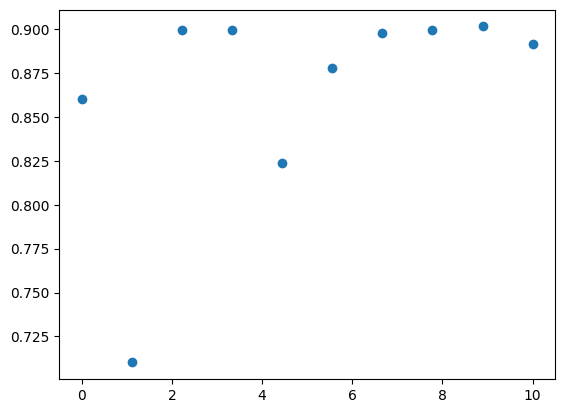

(10,)
Testing Error per epoch


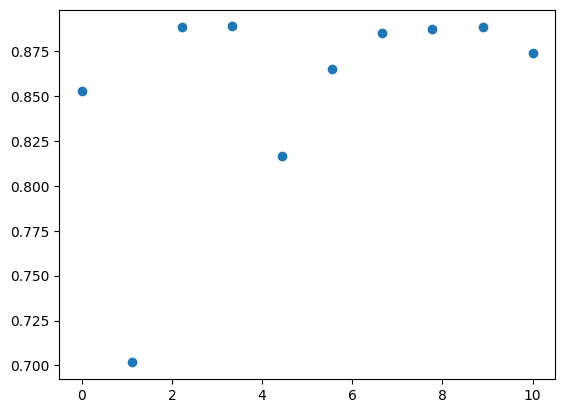

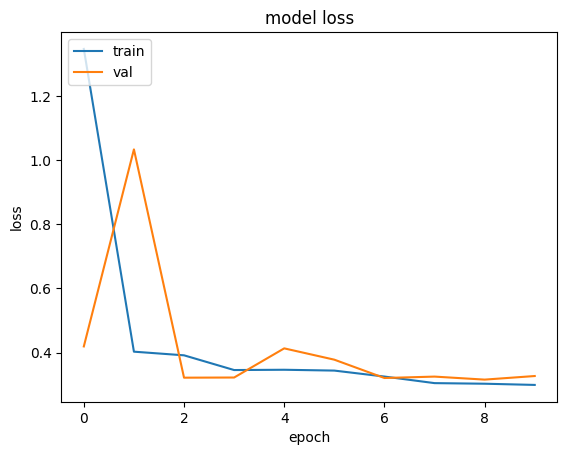

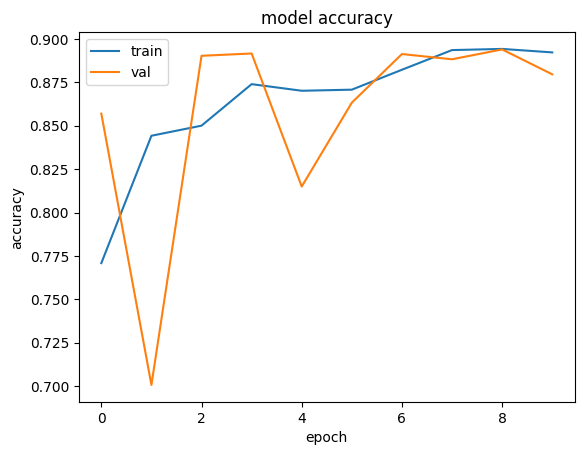

In [13]:
# Get the training and testing data in the appropriate shape
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

print(np.array(x_train).shape)
print(np.array(x_test).shape)
epochs = 10

# One hidden layer NN
NN_1layer = tf.keras.Sequential()

hidden_layer = tf.keras.layers.Dense(units=16, activation='relu')
NN_1layer.add(hidden_layer)

flatten_layer = tf.keras.layers.Flatten()
NN_1layer.add(flatten_layer)

output_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')
NN_1layer.add(output_layer)

NN_1layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

training_error_list = []
testing_error_list = []
NN_history = NN_1layer.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=32, callbacks=[ReportErrorCallback(x_train, y_train, x_test, y_test, training_error_list, testing_error_list)])

NN_1layer.summary()

train_info = NN_1layer.evaluate(x_train, y_train)
test_info = NN_1layer.evaluate(x_test, y_test)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

visualizePerformance(NN_history, epochs, training_error_list, testing_error_list)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 16)                1605648   
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                      

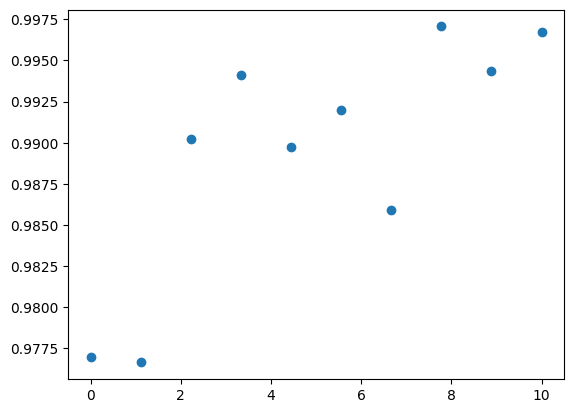

(10,)
Testing Error per epoch


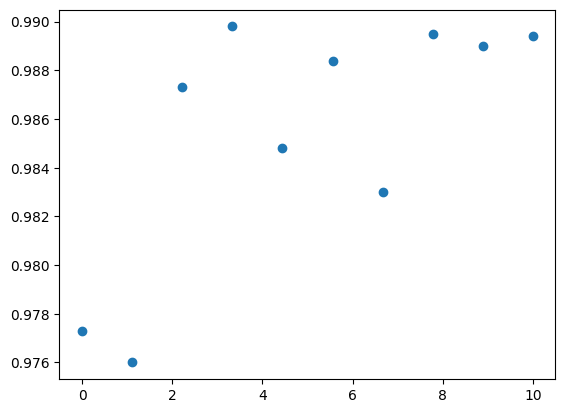

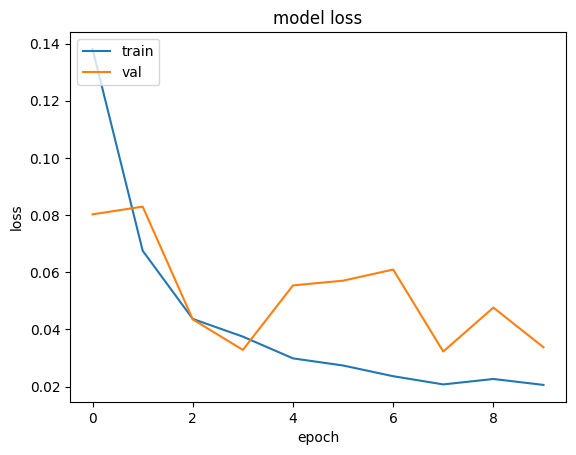

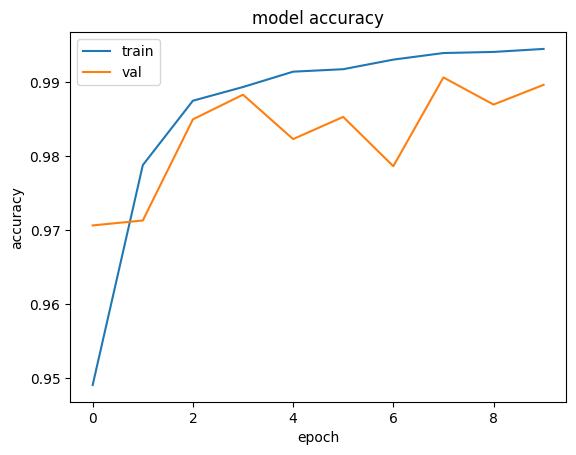

In [11]:
# Data reshaped for CNN
x_train = x_train.reshape(30000, 227, 227)
x_test = x_test.reshape(10000, 227, 227)

epochs = 10
CNN_model = tf.keras.Sequential()

# Convolutional layer 
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(227, 227, 1))
CNN_model.add(conv_layer)

# Max pooling layer 
# TODO: Find optimum pool size 
maxpool_layer = tf.keras.layers.MaxPool2D(pool_size=(4,4))
CNN_model.add(maxpool_layer)

# Flatten layer 
flatten_layer = tf.keras.layers.Flatten()
CNN_model.add(flatten_layer)

# Add two dense layers 
dense_layer1 = tf.keras.layers.Dense(units=16, activation='relu')
CNN_model.add(dense_layer1)
dense_layer2 = tf.keras.layers.Dense(units=16, activation='relu')
CNN_model.add(dense_layer2)

# Add output layer
output_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')
CNN_model.add(output_layer)

# Print out a summary of the model 
CNN_model.summary()

# Compile the model 
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

training_error_list = []
testing_error_list = []

CNN_history = CNN_model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=16, callbacks=[ReportErrorCallback(x_train, y_train, x_test, y_test, training_error_list, testing_error_list)])

train_info = CNN_model.evaluate(x_train, y_train)
test_info = CNN_model.evaluate(x_test, y_test)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

visualizePerformance(CNN_history, epochs, training_error_list, testing_error_list)

## Models Handling Color

New training data shape:  (30000, 114, 114, 3)
New testing data shape:  (10000, 114, 114, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 114, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                             

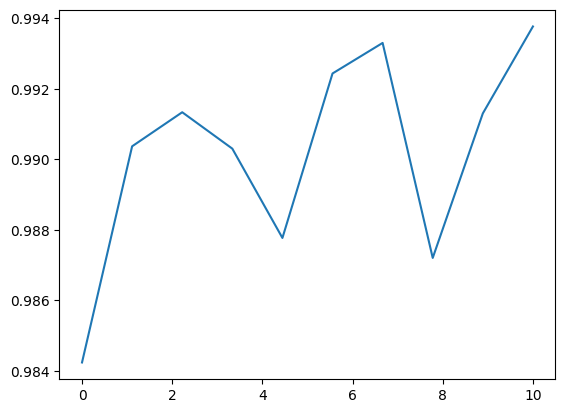

(10,)
Testing Error per epoch


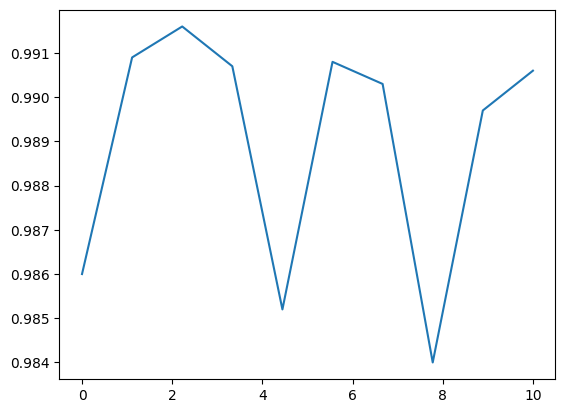

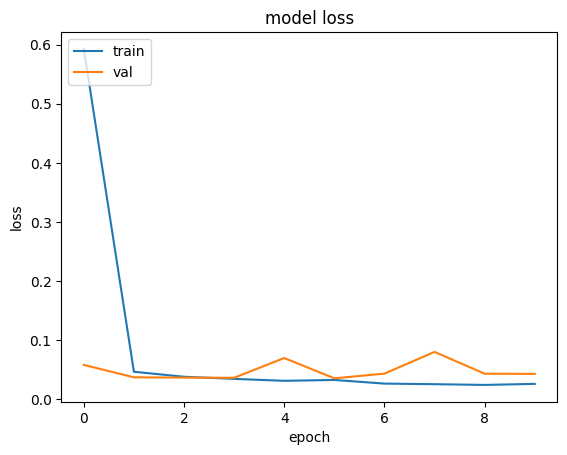

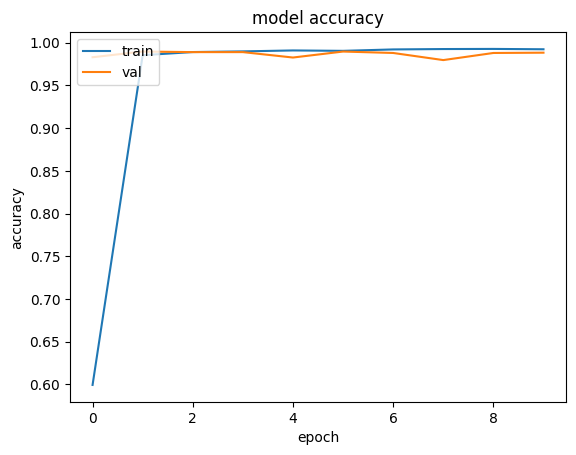

In [6]:
# GOAL: RUN FOR LONGER TO SEE VALIDATION STABILIZE 
# HANDLE COLOR IMAGES

# MODIFICATIONS MADE TO BASELINE CNN:
# 1. LOSS: categorical_crossentropy => binary_crossentropy
# 2. OUTPUT LAYER ACTIVATION: softmax => sigmoid
# 3. CONV2D FILTERS: 32 => 8 (no need for complex filters)
# 4. INPUT SHAPE: (227,227,1) => (114, 114, 3)
# 5. PADDING: "valid" => "same"
# 5. DENSE LAYER: 
# 5. ARCHITECTURE: 2 CONV2D and maxpool layers, one dense layer of 32 instead of two of 16

# Data reshaped for CNN
x_train = x_train.reshape(30000, 227, 227)
x_test = x_test.reshape(10000, 227, 227)

# Bring the color channels back and resize
x_train = convertBackToColor(x_train)
x_test = convertBackToColor(x_test)

print("New training data shape: ", x_train.shape)
print("New testing data shape: ", x_test.shape)

epochs = 10
CNN_model_color = tf.keras.Sequential()
 
conv_layer_1 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', input_shape=(114, 114, 3))
CNN_model_color.add(conv_layer_1)

maxpool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
CNN_model_color.add(maxpool_layer_1)

conv_layer_2 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')
CNN_model_color.add(conv_layer_2)

maxpool_layer_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
CNN_model_color.add(maxpool_layer_2)

# Flatten layer 
flatten_layer = tf.keras.layers.Flatten()
CNN_model_color.add(flatten_layer)

# Add one dense layers 
dense_layer = tf.keras.layers.Dense(units=32, activation='relu')
CNN_model_color.add(dense_layer)

# Add output layer
output_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')
CNN_model_color.add(output_layer)

# Print out a summary of the model 
CNN_model_color.summary()

# Compile the model 
CNN_model_color.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

training_error_list = []
testing_error_list = []

CNN_color_history = CNN_model_color.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=16, callbacks=[ReportErrorCallback(x_train, y_train, x_test, y_test, training_error_list, testing_error_list)])

train_info = CNN_model_color.evaluate(x_train, y_train)
test_info = CNN_model_color.evaluate(x_test, y_test)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

visualizePerformance(CNN_color_history, epochs, training_error_list, testing_error_list)

## Making Predictions on an Independent Dataset 


In [14]:
def compute_accuracy(predictions, labels):
    N = len(predictions)
    accuracy = 0
    for i, label in enumerate(labels):
        if (label[predictions[i]] == 1):
            accuracy += 1

    accuracy_percentage = accuracy / N

    return accuracy_percentage

In [10]:
noisy_negative_pics = 'ConcreteCracks/Noisy/Negative'
noisy_positive_pics = 'ConcreteCracks/Noisy/Positive'

(x_noisy, y_noisy) = data_preprocessing(noisy_negative_pics, noisy_positive_pics, True)

print("Shape of x_noisy", x_noisy.shape)
print("Shape of y_noisy", y_noisy.shape)

# Data reshaped for CNN
x_noisy = x_noisy.reshape(20, 227, 227)

# Bring the color channels back and resize
x_noisy = convertBackToColor(x_noisy)

prediction = CNN_model_color.predict(x_noisy)

Shape of negative images (10, 51530)
Shape of positive images (10, 51530)
Shape of x_noisy (20, 51529)
Shape of y_noisy (20, 2)
1/1 [==============================] - 0s 108ms/step


In [18]:
print("shape of the predictions: ", np.array(prediction).shape)
prediction_class = np.argmax(prediction,axis=1)

accuracy = compute_accuracy(prediction_class, y_noisy) * 100
print("Accuracy on unseen data: ", accuracy, "%")


shape of the predictions:  (20, 2)
Accuracy on unseen data:  85.0 %


## Test Accuracy with images transfromed to add noise

In [30]:
noisy_negative_pics = 'ConcreteCracks/Noisy/Negative'
noisy_positive_pics = 'ConcreteCracks/Noisy/Positive'

(x_basic_transform, y_basic_transform) = data_preprocessing(noisy_negative_pics, noisy_positive_pics, True, 'Basic')

print("Shape of x_basic_transform", x_basic_transform.shape)
print("Shape of y_basic_transform", y_basic_transform.shape)

# Data reshaped for CNN
x_basic_transform = x_basic_transform.reshape(20, 227, 227)

# Bring the color channels back and resize
x_basic_transform = convertBackToColor(x_basic_transform)
prediction_class = np.argmax(prediction,axis=1)

accuracy = compute_accuracy(prediction_class, y_basic_transform) * 100
print("Accuracy on unseen data: ", accuracy, "%")

Shape of negative images (10, 51530)
Shape of positive images (10, 51530)
Shape of x_basic_transform (20, 51529)
Shape of y_basic_transform (20, 2)
Accuracy on unseen data:  65.0 %
